# Week 3 Assignment: Image Segmentation of Handwritten Digits

<img src='https://storage.googleapis.com/tensorflow-3-public/assets/images/m2nist_segmentation.png' alt='m2nist digits'>

In this week's assignment, you will build a model that predicts the segmentation masks (pixel-wise label map) of handwritten digits. This model will be trained on the [M2NIST dataset](https://www.kaggle.com/farhanhubble/multimnistm2nist), a multi digit MNIST. If you've done the ungraded lab on the CamVid dataset, then many of the steps here will look familiar.

You will build a Convolutional Neural Network (CNN) from scratch for the downsampling path and use a Fully Convolutional Network, FCN-8, to upsample and produce the pixel-wise label map. The model will be evaluated using the intersection over union (IOU) and Dice Score. Finally, you will download the model and upload it to the grader in Coursera to get your score for the assignment.

In [4]:
# Install packages for compatibility with the Colab GPU and conversion for the autograder

# NOTE: You can safely ignore errors about version incompatibility of
# Colab-bundled packages (e.g. xarray, pydantic, etc.)

!pip install tf-keras==2.15 --quiet
!pip install tensorflow==2.15 --quiet
!pip install keras==2.15 --quiet

## Exercises

We've given you some boilerplate code to work with and these are the 5 exercises you need to fill out before you can successfully get the segmentation masks.

* [Exercise 1 - Define the Basic Convolution Block](#exercise-1)
* [Exercise 2 - Define the Downsampling Path](#exercise-2)
* [Exercise 3 - Define the FCN-8 decoder](#exercise-3)
* [Exercise 4 - Compile the Model](#exercise-4)
* [Exercise 5 - Model Training](#exercise-5)

## Imports

As usual, let's start by importing the packages you will use in this lab.

In [5]:
import os
import zipfile

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

# Check if you have the correct Tensorflow version
assert tf.__version__ == '2.15.0', f'You have TF v{tf.__version__}. Please install TF and Keras v2.15, and select Runtime > Restart Session'

## Download the dataset

[M2NIST](https://www.kaggle.com/farhanhubble/multimnistm2nist) is a **multi digit** [MNIST](http://yann.lecun.com/exdb/mnist/).
Each image has up to 3 digits from MNIST digits and the corresponding labels file has the segmentation masks.

The dataset is available on [Kaggle](https://www.kaggle.com) and you can find it [here](https://www.kaggle.com/farhanhubble/multimnistm2nist)

To make it easier for you, we're hosting it on Google Cloud so you can download without Kaggle credentials.


In [6]:
# download zipped dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip \
    -O /tmp/m2nist.zip

# find and extract to a local folder ('/tmp/training')
local_zip = '/tmp/m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

--2024-10-23 19:44:29--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  53.8MB/s    in 0.3s    

2024-10-23 19:44:29 (53.8 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



## Load and Preprocess the Dataset

This dataset can be easily preprocessed since it is available as **Numpy Array Files (.npy)**

1. **combined.npy** has the image files containing the multiple MNIST digits. Each image is of size **64 x 84** (height x width, in pixels).

2. **segmented.npy** has the corresponding segmentation masks. Each segmentation mask is also of size **64 x 84**.

This dataset has **5000** samples and you can make appropriate training, validation, and test splits as required for the problem.

With that, let's define a few utility functions for loading and preprocessing the dataset.

In [7]:
BATCH_SIZE = 32

def read_image_and_annotation(image, annotation):
  '''
  Casts the image and annotation to their expected data type and
  normalizes the input image so that each pixel is in the range [-1, 1]

  Args:
    image (numpy array) -- input image
    annotation (numpy array) -- ground truth label map

  Returns:
    preprocessed image-annotation pair
  '''

  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation


def get_training_dataset(images, annos):
  '''
  Prepares shuffled batches of the training set.

  Args:
    images (list of strings) -- paths to each image file in the train set
    annos (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(images, annos):
  '''
  Prepares batches of the validation set.

  Args:
    images (list of strings) -- paths to each image file in the val set
    annos (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):
  '''
  Prepares batches of the test set.

  Args:
    images (list of strings) -- paths to each image file in the test set
    annos (list of strings) -- paths to each label map in the test set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset


def load_images_and_segments():
  '''
  Loads the images and segments as numpy arrays from npy files
  and makes splits for training, validation and test datasets.

  Returns:
    3 tuples containing the train, val, and test splits
  '''

  #Loads images and segmentation masks.
  images = np.load('/tmp/training/combined.npy')
  segments = np.load('/tmp/training/segmented.npy')

  #Makes training, validation, test splits from loaded images and segmentation masks.
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)

You can now load the preprocessed dataset and define the training, validation, and test sets.

In [8]:
# Load Dataset
train_slices, val_slices, test_slices = load_images_and_segments()

# Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

## Let's Take a Look at the Dataset

You may want to visually inspect the dataset before and after training. Like above, we've included utility functions to help show a few images as well as their annotations (i.e. labels).

In [9]:
# Visualization Utilities

# there are 11 classes in the dataset: one class for each digit (0 to 9) plus the background class
n_classes = 11

# assign a random color for each class
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste

  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]

  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array

  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')

  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps. Also overlays the metrics.

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the ground truth label map
    prediction (numpy array) -- the predicted label map
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each class
  '''

  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]

  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) -- batch of images and annotations
    num_images (int) -- number of images to display
  '''
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())


You can view a subset of the images from the dataset with the `list_show_annotation()` function defined above. Run the cells below to see the image on the left and its pixel-wise ground truth label map on the right.

<ipython-input-9-dc81ed44ba48>:136: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


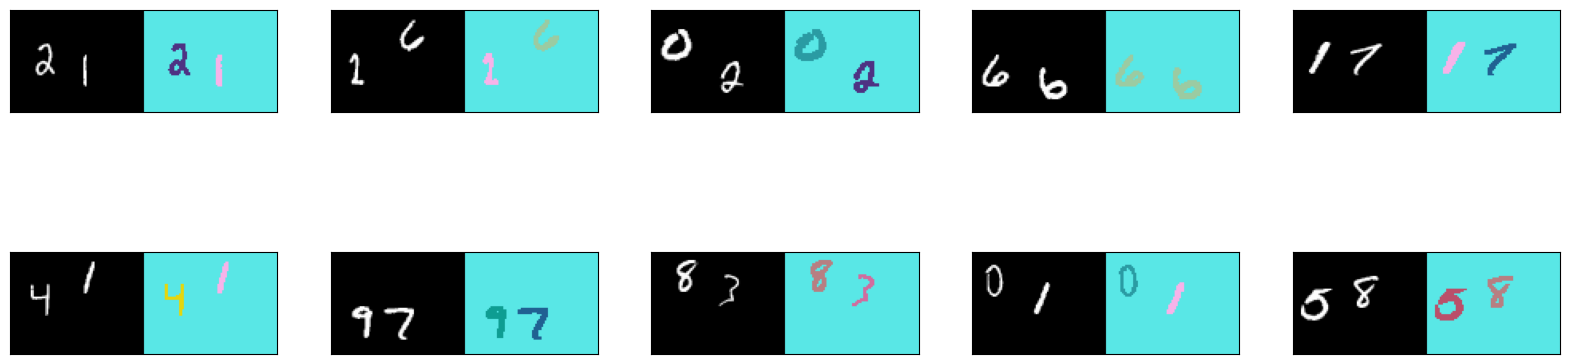

In [10]:
# get 10 images from the training set
list_show_annotation(training_dataset, 10)

<ipython-input-9-dc81ed44ba48>:136: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


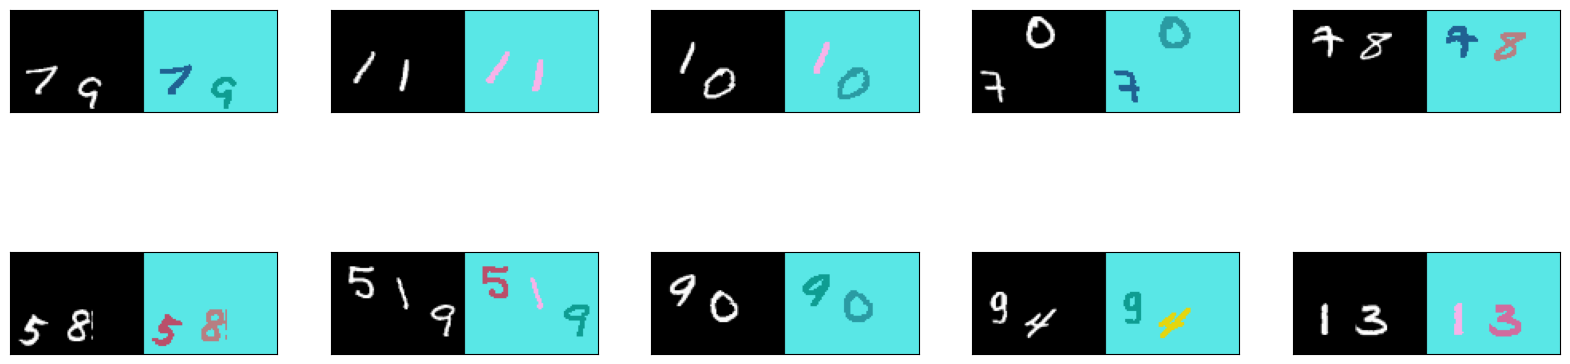

In [11]:
# get 10 images from the validation set
list_show_annotation(validation_dataset, 10)

You see from the images above the colors assigned to each class (i.e 0 to 9 plus the background). If you don't like these colors, feel free to rerun the cell where `colors` is defined to get another set of random colors. Alternatively, you can assign the RGB values for each class instead of relying on random values.

## Define the Model

As discussed in the lectures, the image segmentation model will have two paths:

1. **Downsampling Path** - This part of the network extracts the features in the image. This is done through a series of convolution and pooling layers. The final output is a reduced image (because of the pooling layers) with the extracted features. You will build a custom CNN from scratch for this path.

2. **Upsampling Path** - This takes the output of the downsampling path and generates the predictions while also converting the image back to its original size. You will use an FCN-8 decoder for this path.

### Define the Basic Convolution Block

<a name='exercise-1'></a>

#### **Exercise 1**

Please complete the function below to build the basic convolution block for our CNN. This will have two [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layers each followed by a [LeakyReLU](https://keras.io/api/layers/activation_layers/leaky_relu/), then [max pooled](https://keras.io/api/layers/pooling_layers/max_pooling2d/) and [batch-normalized](https://keras.io/api/layers/normalization_layers/batch_normalization/). Use the functional syntax to stack these layers.

$$Input -> Conv2D -> LeakyReLU -> Conv2D -> LeakyReLU -> MaxPooling2D -> BatchNormalization$$

When defining the Conv2D layers, note that our data inputs will have the 'channels' dimension last. You may want to check the `data_format` argument in the [docs](https://keras.io/api/layers/convolution_layers/convolution2d/) regarding this. Take note of the `padding` argument too like you did in the ungraded labs.

In [13]:
# parameter describing where the channel dimension is found in our dataset
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides):
  '''
  Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    kernel_size (int) -- kernel_size setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers

  Returns:
    (tensor) max pooled and batch-normalized features of the input
  '''
  ### START CODE HERE ###
  # use the functional syntax to stack the layers as shown in the diagram above
  x = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size,  padding="same")(input)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, padding="same")(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=pooling_size, strides=pool_strides, data_format=IMAGE_ORDERING)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  ### END CODE HERE ###

  return x

In [14]:
# TEST CODE:

test_input = tf.keras.layers.Input(shape=(64,84, 1))
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

print(test_model.summary())

# free up test resources
del test_input, test_output, test_model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 84, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 84, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 84, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 84, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 84, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 42, 32)        0         
 D)                                                              
                                                             

**Expected Output**:

Please pay attention to the *(type)* and *Output Shape* columns. The *Layer* name beside the type may be different depending on how many times you ran the cell (e.g. `input_7` can be `input_1`)

```txt
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 64, 84, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 84, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 84, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 84, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 84, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 42, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 42, 32)        128       
=================================================================
Total params: 9,696
Trainable params: 9,632
Non-trainable params: 64
_________________________________________________________________
None
```

### Define the Downsampling Path

<a name='exercise-2'></a>

#### **Exercise 2**

Now that we've defined the building block of our encoder, you can now build the downsampling path. Please complete the function below to create the encoder. This should chain together five convolution building blocks to create a feature extraction CNN minus the fully connected layers.

*Notes*:
1. To optimize processing or to make the output dimensions of each layer easier to work with, it is sometimes advisable to apply some zero-padding to the input image. With the boilerplate code we have provided below, we have padded the input width to 96 pixels using the [ZeroPadding2D layer](https://keras.io/api/layers/reshaping_layers/zero_padding2d/). This works well if you're going to use the first ungraded lab of this week as reference. This is not required however. You can remove it later and see how it will affect your parameters. For instance, you might need to pass in a non-square kernel size to the decoder in Exercise 3 (e.g. `(4,5)`) to match the output dimensions of Exercise 2.

2. We recommend keeping the pool size and stride parameters constant at 2.

In [15]:
def FCN8(input_height=64, input_width=84):
    '''
    Defines the downsampling path of the image segmentation model.

    Args:
      input_height (int) -- height of the images
      width (int) -- width of the images

    Returns:
    (tuple of tensors, tensor)
      tuple of tensors -- features extracted at blocks 3 to 5
      tensor -- copy of the input
    '''

    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))

    ### START CODE HERE ###

    x = tf.keras.layers.ZeroPadding2D(padding=(0, int((96-input_width)/2)))(img_input)

    # Block 1 32, 3, 2, 2
    x = conv_block(x, 32, 3, 2, 2)

    # Block 2
    x =  conv_block(x, 64, 3, 2, 2)

    # Block 3
    x =  conv_block(x, 128, 3, 2, 2)
    # save the feature map at this stage
    f3 = x

    # Block 4
    x = conv_block(x, 256, 3, 2, 2)
    # save the feature map at this stage
    f4 = x

    # Block 5
    x = conv_block(x, 256, 3, 2, 2)
    # save the feature map at this stage
    f5 = x

    ### END CODE HERE ###

    return (f3, f4, f5), img_input

In [16]:
# TEST CODE:

test_convs, test_img_input = FCN8()
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input])

print(test_model.summary())

del test_convs, test_img_input, test_model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 84, 1)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 64, 96, 1)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 96, 32)        320       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64, 96, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 96, 32)        9248      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 96, 32)        0         
                                                           

**Expected Output**:

You should see the layers of your `conv_block()` being repeated 5 times like the output below.

```txt
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_3 (InputLayer)         [(None, 64, 84, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 64, 96, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 96, 32)        320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 96, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 96, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 48, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 48, 64)        18496     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 48, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 48, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 48, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 24, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 24, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 24, 128)       73856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 24, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 24, 128)       147584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 24, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 12, 128)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 12, 128)        512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 12, 256)        295168    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 12, 256)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 12, 256)        590080    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 12, 256)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 6, 256)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 6, 256)         1024      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 6, 256)         590080    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 4, 6, 256)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 6, 256)         590080    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4, 6, 256)         0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 3, 256)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2, 3, 256)         1024      
=================================================================
Total params: 2,354,784
Trainable params: 2,353,312
Non-trainable params: 1,472
_________________________________________________________________
None
```

### Define the FCN-8 decoder

<a name='exercise-3'></a>

#### **Exercise 3**

Now you can define the upsampling path taking the outputs of convolutions at each stage as arguments. This will be very similar to what you did in the ungraded lab (VGG16-FCN8-CamVid) so you can refer to it if you need a refresher.
* Note: remember to set the `data_format` parameter for the Conv2D layers.

Here is also the diagram you saw in class on how it should work:

<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8'>

In [40]:
def fcn8_decoder(convs, n_classes):
  # features from the encoder stage
  f3, f4, f5 = convs

  # number of filters
  n = 512

  # add convolutional layers on top of the CNN extractor.
  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o)


  ### START CODE HERE ###

  # Upsample `o` above and crop any extra pixels introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)

  # append a sigmoid activation
  o =  (tf.keras.layers.Activation('sigmoid'))(o)
  ### END CODE HERE ###

  return o

In [41]:
# TEST CODE

test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 11)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 84, 11)


**Expected Output:**

```txt
(None, 64, 84, 11)
```

### Define the Complete Model

The downsampling and upsampling paths can now be combined as shown below.

In [42]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
dec_op = fcn8_decoder(convs, n_classes)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

In [43]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 64, 84, 1)]          0         []                            
                                                                                                  
 zero_padding2d_22 (ZeroPad  (None, 64, 96, 1)            0         ['input_24[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv2d_253 (Conv2D)         (None, 64, 96, 32)           320       ['zero_padding2d_22[0][0]']   
                                                                                                  
 leaky_re_lu_222 (LeakyReLU  (None, 64, 96, 32)           0         ['conv2d_253[0][0]']    

## Compile the Model

<a name='exercise-4'></a>

### **Exercise 4**

Compile the model using an appropriate loss, optimizer, and metric.

In [45]:
### START CODE HERE ###
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
### END CODE HERE ###

## Model Training

<a name='exercise-5'></a>

### **Exercise 5**

You can now train the model. Set the number of epochs and observe the metrics returned at each iteration. You can also terminate the cell execution if you think your model is performing well already.

In [ ]:
# OTHER THAN SETTING THE EPOCHS NUMBER, DO NOT CHANGE ANY OTHER CODE

### START CODE HERE ###
EPOCHS = 50
### END CODE HERE ###

steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE


history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/50
 19/125 [===>..........................] - ETA: 7:35 - loss: 2.3859 - accuracy: 0.1498

**Expected Output:**

The losses should generally be decreasing and the accuracies should generally be increasing. For example, observing the first 4 epochs should output something similar:

```txt
Epoch 1/70
125/125 [==============================] - 6s 50ms/step - loss: 0.5542 - accuracy: 0.8635 - val_loss: 0.5335 - val_accuracy: 0.9427
Epoch 2/70
125/125 [==============================] - 6s 47ms/step - loss: 0.2315 - accuracy: 0.9425 - val_loss: 0.3362 - val_accuracy: 0.9427
Epoch 3/70
125/125 [==============================] - 6s 47ms/step - loss: 0.2118 - accuracy: 0.9426 - val_loss: 0.2592 - val_accuracy: 0.9427
Epoch 4/70
125/125 [==============================] - 6s 47ms/step - loss: 0.1782 - accuracy: 0.9431 - val_loss: 0.1770 - val_accuracy: 0.9432
```

## Model Evaluation

### Make Predictions

Let's get the predictions using our test dataset as input and print the shape.

In [ ]:
results = model.predict(test_dataset, steps=test_steps)

print(results.shape)

As you can see, the resulting shape is `(192, 64, 84, 11)`. This means that for each of the 192 images that we have in our test set, there are 11 predictions generated (i.e. one for each class: 0 to 1 plus background).

Thus, if you want to see the *probability* of the upper leftmost pixel of the 1st image belonging to class 0, then you can print something like `results[0,0,0,0]`. If you want the probability of the same pixel at class 10, then do `results[0,0,0,10]`.




In [ ]:
print(results[0,0,0,0])
print(results[0,0,0,10])

What we're interested in is to get the *index* of the highest probability of each of these 11 slices and combine them in a single image. We can do that by getting the [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) at this axis.

In [ ]:
results = np.argmax(results, axis=3)

print(results.shape)

The new array generated per image now only specifies the indices of the class with the highest probability. Let's see the output class of the upper most left pixel. As you might have observed earlier when you inspected the dataset, the upper left corner is usually just part of the background (class 10). The actual digits are written somewhere in the middle parts of the image.

In [ ]:
print(results[0,0,0])

# prediction map for image 0
print(results[0,:,:])

We will use this `results` array when we evaluate our predictions.

### Metrics

We showed in the lectures two ways to evaluate your predictions. The *intersection over union (IOU)* and the *dice score*. Recall that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

The code below does that for you as you've also seen in the ungraded lab. A small smoothing factor is introduced in the denominators to prevent possible division by zero.

In [ ]:
def class_wise_metrics(y_true, y_pred):
  '''
  Computes the class-wise IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label maps
    y_pred (tensor) - predicted label maps
  '''
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


### Visualize Predictions

In [ ]:
# place a number here between 0 to 191 to pick an image from the test set
integer_slider = 105

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image


iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


### Compute IOU Score and Dice Score of your model

In [ ]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score))
  average_iou += iou

grade = average_iou * 10

print("\nGrade is " + str(grade))

PASSING_GRADE = 60
if (grade>PASSING_GRADE):
  print("You passed!")
else:
  print("You failed. Please check your model and re-train")

## Save the Model

Once you're satisfied with the results, you can save your model and upload it to the grader in Coursera. Please run all succeeding cells to ensure that you will have a gradable submission. Otherwise, you might get this error message:

`There was a problem grading your submission. Check stderr for more details.`

First, save the model file in your Colab workspace.

In [ ]:
# Save the model you just trained
model.save("temp_model.h5")

Tensorflow releases minor and patch updates every few months ([sometimes quicker](https://pypi.org/project/tensorflow/#history)). Oftentimes, the code and syntax won't change but the newer versions will have a different model definition under the hood. The next cells will convert your newer model to one that the grader can read. You won't have to do this in your personal projects. This is just an extra step for grading.

In [ ]:
# Install packages for compatibility with the autograder

# NOTE: You can safely ignore errors about version incompatibility of
# Colab-bundled packages (e.g. xarray, pydantic, etc.)

!pip install tensorflow==2.8.0 --quiet
!pip install keras==2.8.0 --quiet

Wait for the cell above to complete. After that, **go to `Runtime > Restart Session` and wait for the kernel to reconnect.** This is necessary so you can reload Tensorflow with the version installed above. Run the next cell to check if you have the correct version. You will get an `AssertionError` if you didn't restart the session.

In [ ]:
import tensorflow as tf

# Check if you have the correct Tensorflow version
assert tf.__version__ == '2.8.0', f'You have TF{tf.__version__}. Please install the grader-compatible Tensorflow and select Runtime > Restart Session'

If you didn't get an error above, you can finally convert the model.

In [ ]:
# Load the model you saved earlier
model = tf.keras.models.load_model("temp_model.h5", compile=False)

# Re-save the model with the compatible TF version
model.save("final_model.h5")

Please look for `final_model.h5` in the File Explorer on the left and download it. Then go back to the Coursera classroom and upload it to the Lab item that points to the autograder of Week 3. Alternatively, you can also use the cell below to download the model.



In [ ]:
# You can also use this cell as a shortcut for downloading your model
from google.colab import files
files.download("final_model.h5")

**Congratulations on completing this assignment on image segmentation!**